In [418]:
import pandas as pd
import geopandas as geopd
import seaborn as sea 
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, dataframe
from pyspark.sql import functions as f
from pyspark.sql.types import *

### Data & AI - PB Fast Learning - Ciência de Dados - 1/3

<div align="center">
    <img src='img/hierarquia.png' width="590px"/>
</div>

&nbsp;

Criando Seção no spark

In [419]:
spark = SparkSession.builder.master('local')\
    .appName('ProjetoSprint01')\
    .getOrCreate()

In [420]:
spark.sparkContext

<SparkContext master=local appName=ProjetoSprint01>

Carregando dados usando pyspark

In [421]:
# olist_customers_dataset
customers     = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_customers_dataset.csv')

# olist_geolocation_dataset
schemaGeo = StructType([ 
    StructField("geolocation_zip_code_prefix", StringType(), True),
    StructField("geolocation_lat", DoubleType(), True),
    StructField("geolocation_lng", DoubleType(), True),
    StructField("geolocation_city", StringType(), True),
    StructField("geolocation_state", StringType(), True)
])
geolocation   = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').schema(schemaGeo)\
        .load('dataset/olist_geolocation_dataset.csv')

# olist_order_payments_dataset
payments      = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_order_payments_dataset.csv')

# olist_orders_dataset
orders        = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_orders_dataset.csv')

# olist_order_items_dataset
order_items   = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_order_items_dataset.csv')

# olist_order_reviews_dataset
order_reviews = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_order_reviews_dataset.csv')

# olist_products_dataset
order_product = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_products_dataset.csv')

# olist_sellers_dataset

schemaSeller = StructType([
    StructField("seller_id", StringType(), True),
    StructField("seller_zip_code_prefix", StringType(), True),
    StructField("seller_city", StringType(), True),
    StructField("seller_state", StringType(), True)
])
sellers      = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').schema(schemaSeller)\
        .load('dataset/olist_sellers_dataset.csv')

# product_category_dataset
product_cat  = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/product_category_name_translation.csv')

Criando uma visão temporaria , pois usarei o sql do spark para fazer as questões

In [422]:
customers.createOrReplaceTempView('customers')
geolocation.createOrReplaceTempView('geolocation')
orders.createOrReplaceTempView('orders')
order_items.createOrReplaceTempView('order_items')
order_product.createOrReplaceTempView('order_product')
order_reviews.createOrReplaceTempView('order_reviews')
payments.createOrReplaceTempView('payments')
sellers.createOrReplaceTempView('sellers')
product_cat.createOrReplaceTempView('product_cat')

&nbsp;

## Analise

&nbsp;

### Quais são categorias com maior e menor receita dos ultimos 12 meses?

In [423]:
query = '''
select min(order_purchase_timestamp), max(order_purchase_timestamp)  from orders;
'''
spark.sql(query).toPandas()

,min(order_purchase_timestamp),max(order_purchase_timestamp)
0,2016-09-04 21:15:19,2018-10-17 17:30:18


> O data vão de 2016 a 2019

Usando **Sql Spark** para fazer as questões \
Fazendo o `INNER JOIN` nas repestivas tabelas abaixo e com o `order_status!=cancelado` ,pois so será computado as vendas feitas(ou seja diferente de cancelado) assim consigo obter o valor real das Receitas de um produto, vender, estado.....
> Essa logica será feitas sobre as questões adiante que pedem `receitas` de algo

In [424]:
query = '''
SELECT product_category_name, SUM(payment_value) as Receita FROM order_items as o_i
    INNER JOIN order_product as o_p ON
        o_p.product_id = o_i.product_id
    INNER JOIN orders as or ON
        or.order_id = o_i.order_id
    INNER JOIN payments as pay ON
        pay.order_id = or.order_id

    WHERE order_status != 'canceled' and
        order_purchase_timestamp >= '2017-10-15 01:00:00' and
        order_purchase_timestamp <= '2018-10-17 17:30:18'
    GROUP BY product_category_name
    ORDER BY receita desc;
'''
# Transformando dataframe do spark em pandas dataframe para usar na visualização
data = spark.sql(query).toPandas()

Modificando a coluna `product_category_name` para torna-la mais legivel

In [425]:
# Tirar o `_` e colacando o ' ' (espaco vazio) usando o replace
data['product_category_name'] = data['product_category_name'].str.replace('_',' ')
# Deixando as primeiras letras de cada palavra maiuscula
data['product_category_name'] = data['product_category_name'].str.title()

Usarei seaborn e matplotlib para visualização pois ele renderiza no github, diferente do plotly

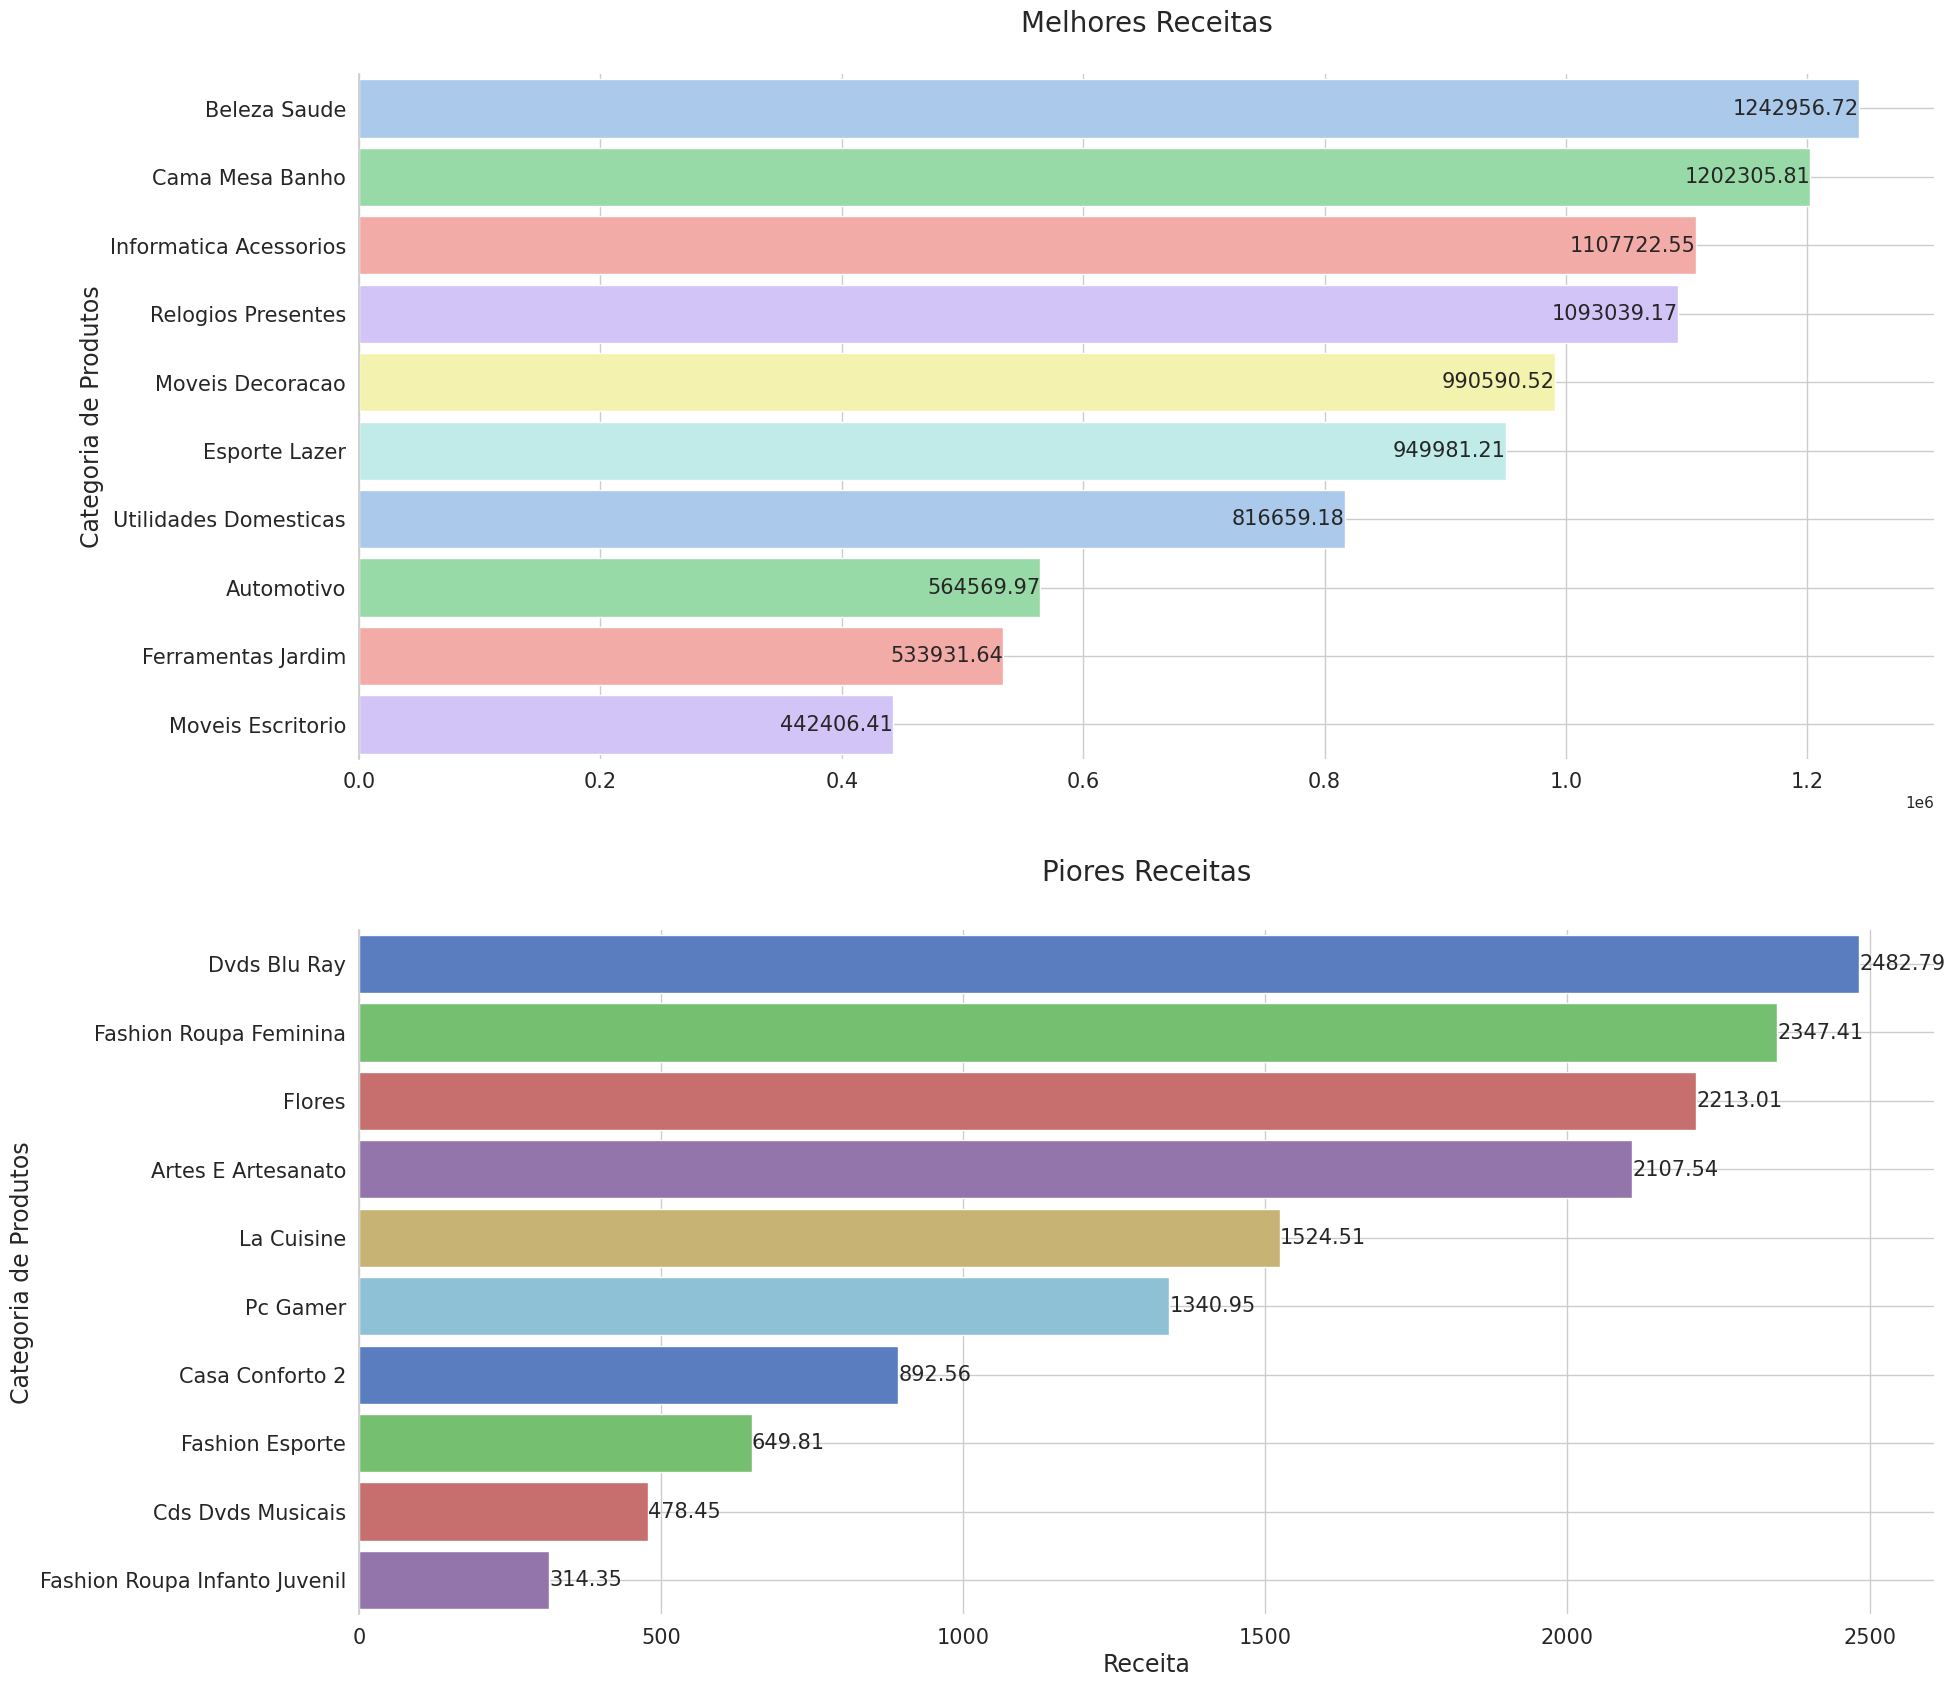

In [426]:
sea.set_theme(style="whitegrid")                # Definindo estilo
fig, ax = plt.subplots(ncols=1,nrows=2,figsize=(18,20))
fig.subplots_adjust(hspace=0.25,right=1)        # Aumenta o espaço entre os graficos

# Grafico 1 = Melhores receitas
# Criando o grafico 1 com as melhores receitas
barMelhores = sea.barplot( data = data.iloc[0:10,:], 
    y='product_category_name', x='Receita', hue='product_category_name',width=0.85,
    palette=sea.color_palette('pastel6',n_colors=10), ax = ax[0], legend=False
)

#Modificando o Grafico 1
ax[0].set_title('Melhores Receitas',y=1.05,fontsize=20)
ax[0].set_ylabel('Categoria de Produtos',x=10,fontsize=17)
ax[0].set_xlabel('')
ax[0].spines[['right','top','bottom']].set_visible(False)
ax[0].tick_params('y', labelsize=15)
ax[0].tick_params('x', labelsize=15)         
ax[0].set_axisbelow(True)
ax[0].grid(True)

# Colocando o valor das receitas nas barras
for p in barMelhores.patches:
    if p.get_width() != 0:
        barMelhores.annotate(("%.2f" % p.get_width()),  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'right', va = "center" ,size=15)

# Grafico 2 = Piores receitas
barPiores = sea.barplot(data=data.iloc[63:76,:], 
    y='product_category_name', x='Receita', hue='product_category_name',width=0.85,
    palette =  sea.color_palette('muted6',n_colors=10), ax = ax[1], legend=False
)
for p in barPiores.patches:
    if p.get_width() != 0:
        barPiores.annotate("%.2f" % p.get_width(),  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'left', va = "center" ,size=15)

#Modificando o Grafico 2
ax[1].set_title('Piores Receitas',y=1.06,fontsize=20)       # Titulo 
ax[1].set_ylabel('Categoria de Produtos',x=10,fontsize=17)  # Modificando eixo y
ax[1].set_xlabel('Receita',fontsize=17)                     # Modificando eixo x
ax[1].spines[['right','top','bottom']].set_visible(False)   # Visibilidade das bordas
ax[1].tick_params('y', labelsize=15)  
ax[1].tick_params('x', labelsize=15)                        # Fonte do eixo y
ax[1].set_axisbelow(True)
ax[1].grid(True) 

plt.show()

&nbsp;

### Top 10 maiores sellers (maior receita)?

In [427]:
query = '''
SELECT (INITCAP(se.seller_city)|| '-' || se.seller_state) as seller ,
        ROUND(sum(payment_value),2) as receita FROM sellers AS se
    INNER JOIN order_items AS o_i ON
        o_i.seller_id = se.seller_id
    INNER JOIN payments AS py ON
        py.order_id  = o_i.order_id
    INNER JOIN orders AS o_r ON
        o_r.order_id = py.order_id
    WHERE order_status != 'canceled'  
    GROUP BY seller
    ORDER BY receita desc limit 10; 
'''
data = spark.sql(query).toPandas()

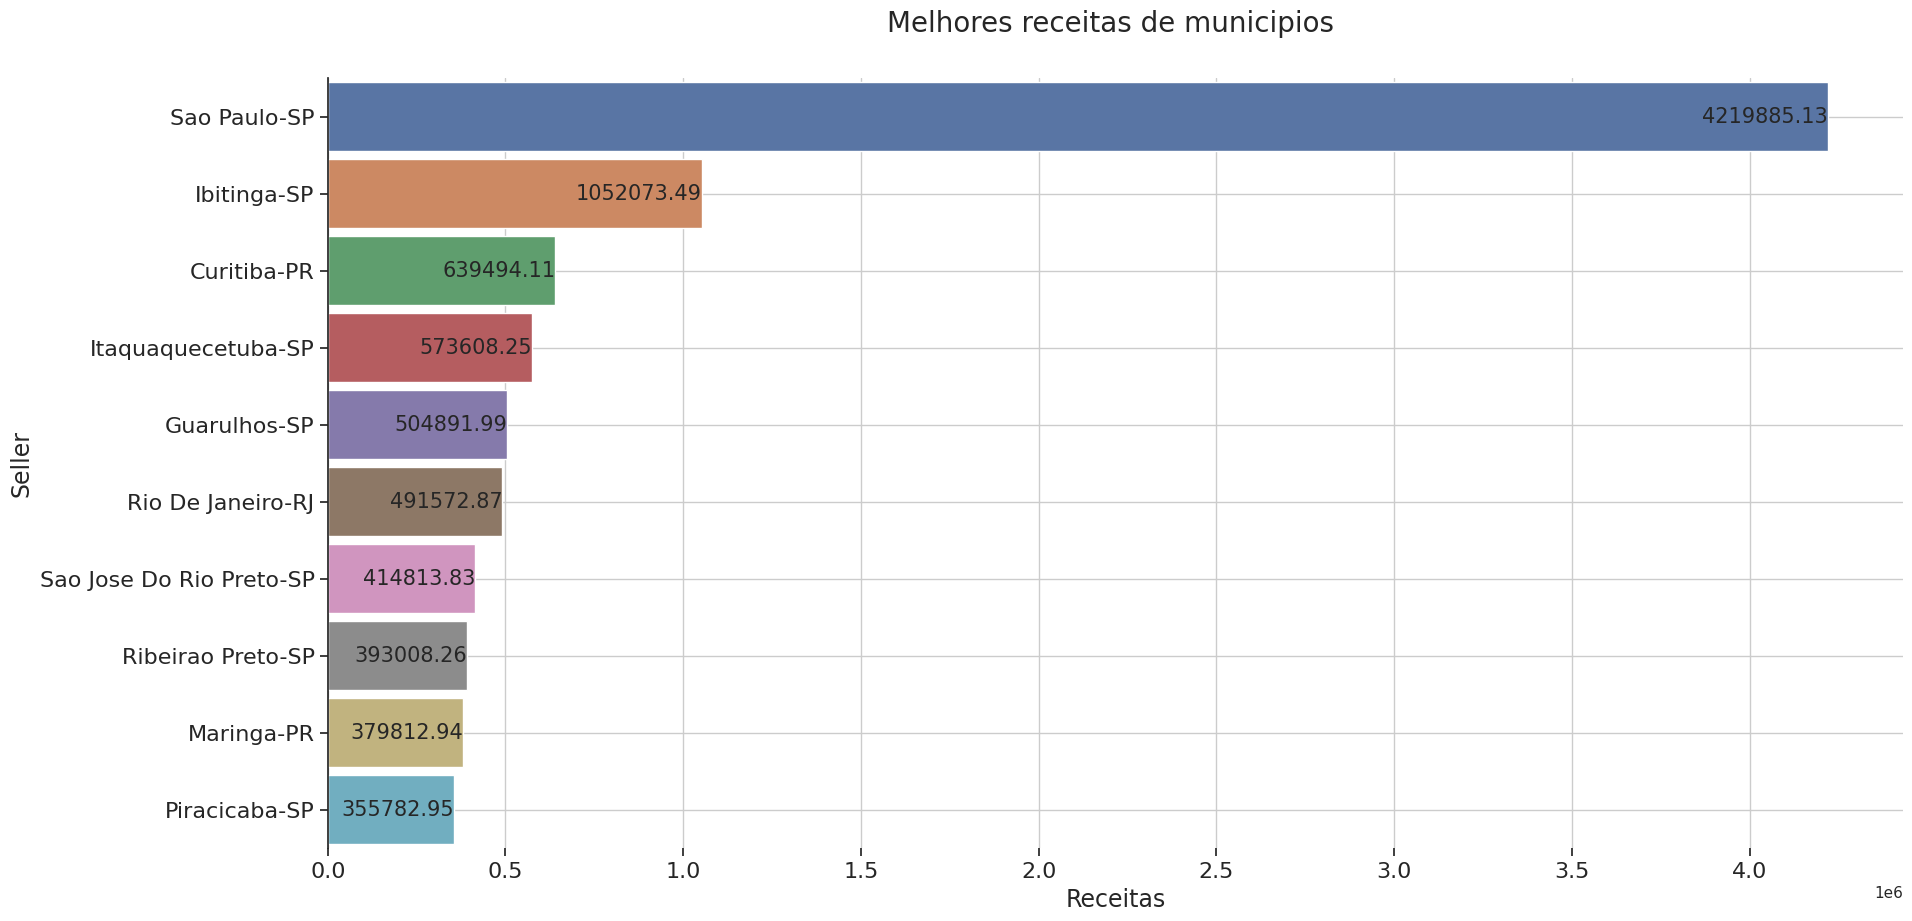

In [428]:
sea.set_theme(style="ticks")                # Definindo estilo
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(18,10))
fig.subplots_adjust(hspace=0.25,right=1)        # Aumenta o espaço entre os graficos

# Grafico 1 = Melhores receitas
# Criando o grafico 1 com as melhores receitas
barMelhores = sea.barplot( data = data.iloc[0:10,:], 
    y='seller', x='receita', hue='seller', width=0.9, ax = ax, legend=False
)

#Modificando o Grafico 1
ax.set_title('Melhores receitas de municipios ',y=1.05,fontsize=20)
ax.set_ylabel('Seller',x=10,fontsize=17)
ax.set_xlabel('Receitas',fontsize=17)
ax.spines[['right','top','bottom']].set_visible(False)
ax.tick_params('y', labelsize=16)
ax.tick_params('x', labelsize=16)         
ax.set_axisbelow(True)
ax.grid(True)

# Colocando o valor das receitas nas barras
for p in barMelhores.patches:
    if p.get_width() != 0:
        barMelhores.annotate(("%.2f" % p.get_width()),  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'right', va = "center" ,size=15)

In [429]:
query = '''
SELECT se.seller_state as seller ,
        ROUND(sum(payment_value),2) as receita FROM sellers AS se
    INNER JOIN order_items AS o_i ON
        o_i.seller_id = se.seller_id
    INNER JOIN payments AS py ON
        py.order_id  = o_i.order_id
    INNER JOIN orders AS o_r ON
        o_r.order_id = py.order_id
    WHERE order_status != 'canceled'  
    GROUP BY seller
    ORDER BY receita DESC LIMIT 10; 
'''
data = spark.sql(query).toPandas()
data

,seller,receita
0,SP,13274480.82
1,PR,1831764.46
2,MG,1553087.26
3,RJ,1091783.25
4,SC,867134.62
5,RS,559309.41
6,BA,367627.38
7,DF,137057.02
8,PE,124830.78
9,GO,111971.06


Importei um json para plotar o mapa do brasil

In [430]:
geo  = geopd.read_file('Brasil/Brasil.json')
geoMerge = pd.merge(right=data , right_on='seller',left=geo, left_on='UF',how='inner')

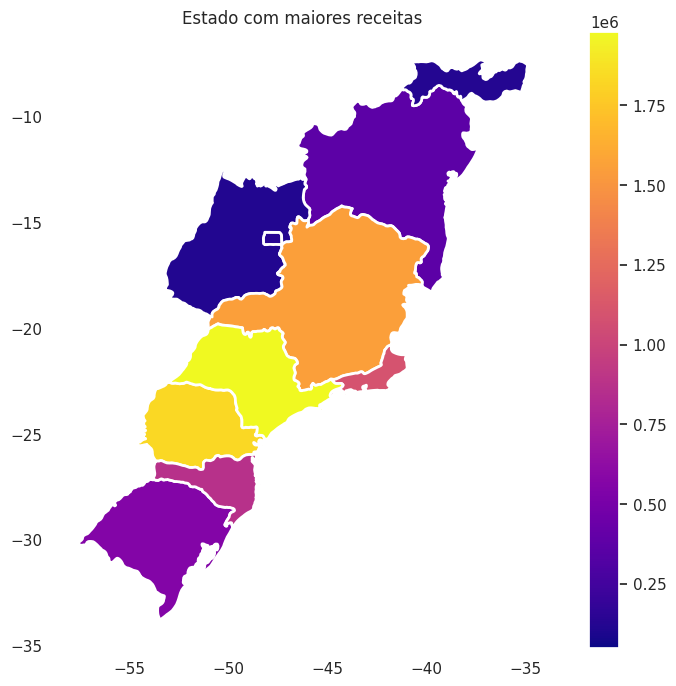

In [431]:
sea.set_theme('notebook')
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fig.subplots_adjust(hspace=0.9)
geoMerge.plot(ax=ax,column='receita',cmap=sea.color_palette('plasma', as_cmap=True),legend=True,linewidth=2,vmin=50000,vmax=1980000)
ax.set_facecolor('white')
plt.title('Estado com maiores receitas')
plt.grid(False)
plt.show()

###